# Predict pay price
本文使用中间数据集的特征预测7日后付费的用户（包括复购和新付费用户）。

通过对5大类因子有效性的研究得到有效的模型输入. 筛选因子的主要方法：
1. 大类中的因子等权平均
2. 大类中的因子用PCA压缩（矩阵正交），得到最大解释比例的因子
3. stepwise(RFE)，通过ploy, cross product产生的新因子，使用模型迭代筛选出最有效的因子

## Solution: Feature Tools

In [1]:
# improt packages
import pandas as pd
import pprint
import tableprint as tp
import itertools as it
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pylab as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

font0 = FontProperties()
alignment = {'horizontalalignment': 'center', 'verticalalignment': 'baseline'}
# Show family options

families = ['serif', 'sans-serif', 'cursive', 'fantasy', 'monospace']

font1 = font0.copy()
font1.set_size('large')
plt.style.use('ggplot')
pp = pprint.PrettyPrinter(indent=4)

%matplotlib inline

读取X和y，均为未标准化数据集, y为log后的数据

In [385]:
USELESS_COLUMNS = [#'stone_net',
    ]

NUMERICAL_COLUMNS = [
    # active/payment features
     'day_num',
    'avg_online_minutes', 'pay_price', 'pay_price_per_hour', 'is_active_user',
    'dayofweek', 
    'sr_main_var', 'sr_level_var', 'net_var', 'mean_wood_net_var'
    # war features
    'battle_win%',
    # achievement features
    'resource_add', 'acceleration_add'
    'acct_value_zs', 'resource_reduce', 'army_reduce'
    'sr_main_score',
    # add features
    'stone_add_value', 'ivory_add_value', 'general_acceleration_add_value',
       'training_acceleration_add_value'
    # reduce features
    'wood_reduce_value', 'ivory_reduce_value',
       'general_acceleration_reduce_value',
       'reaserch_acceleration_reduce_value',
    # net features
    'meat_net', 'cavalry_net', 'general_acceleration_net',
       'training_acceleration_net',
    # ratio features
    'acceleration_army_add_ratio', 'resource_army_add_ratio',
       'bd_resource_ratio',
    # mix features
    'sr_army_prod',
    'bd_sr_product',
]
NUMERICAL_COLUMNS = list(filter(lambda x: x not in USELESS_COLUMNS, NUMERICAL_COLUMNS))

CATEGORICAL_COLUMNS = [
    'pay_price_group',
    'register_timecls',
    'avg_online_minutes_group',
]


In [433]:
%%time
df_train = pd.read_parquet('../data/tap_fun_train.parquet')

Wall time: 7.41 s


In [434]:
%time df_test = pd.read_parquet('../data/tap_fun_test.parquet')

Wall time: 3.03 s


In [435]:
df_train['prediction_future_pay_price'] = df_train['prediction_pay_price'] - df_train['pay_price']
df_train = df_train.assign(is_future_pay= lambda x: x.prediction_future_pay_price>0)
NUMERICAL_COLUMNS = list(filter(lambda x:x in df_train.columns, NUMERICAL_COLUMNS))
USE_COLUMNS = NUMERICAL_COLUMNS 
TARGET_COLUMN=['prediction_future_pay_price']

In [436]:
from dask import dataframe as dd

df_sm = df_train[df_train.avg_online_minutes>20]
dd_sm = dd.from_pandas(df_sm,npartitions=4)

In [437]:
X = df_train[USE_COLUMNS]
y = df_train[TARGET_COLUMN]

In [438]:
X = X[X.avg_online_minutes>20]
y = y.loc[X.index]
# X =X.reset_index(drop=True)
X.shape

(182415, 26)

In [439]:
X_test = df_test[NUMERICAL_COLUMNS]

In [440]:
df_pay_day7=  df_train[df_train['pay_price']>0]
same_pay_cnt = df_pay_day7[df_pay_day7['pay_price']==df_pay_day7['prediction_pay_price']]['user_id'].count()
less_pay_cnt = df_pay_day7[df_pay_day7['pay_price']>df_pay_day7['prediction_pay_price']]['user_id'].count()
day7_cnt = df_pay_day7['user_id'].count()

tp.table([[day7_cnt,same_pay_cnt,less_pay_cnt]],['day7 pay#', 'no future pay#', 'samll pay#'])

╭─────────────┬─────────────┬─────────────╮
│  day7 pay#  │ no future pay# │ samll pay#  │
├─────────────┼─────────────┼─────────────┤
│       41439 │       30130 │           0 │
╰─────────────┴─────────────┴─────────────╯


In [441]:
df_variable = pd.read_excel('../data/tap4fun.xlsx',sheet_name='Sheet1')
df_variable = df_variable.iloc[:,range(3)].rename(columns={'字段名':'column','字段解释':'desc','数据时间':'cycle'})
df_variable['cat'] = df_variable.column.str.split('_').apply(lambda x: x[0])


由于前7日的非活跃用户几乎不可能付费，模型输入把这部分数据排除

In [442]:
y_log = np.log(y.values.ravel()+1)
print("row count exclude inactive users:%d"%X.shape[0])

row count exclude inactive users:182415


In [443]:
df_joint = pd.concat([df_train, df_test])
df_joint = df_joint[df_joint.avg_online_minutes>20]

因子有效性研究
- 不同的归一化方式会影响数据分布吗? standard score and ipsantation change distribution

In [445]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, minmax_scale
from sklearn.linear_model import LarsCV
from sklearn.feature_selection import SelectFromModel
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
from sklearn.pipeline import make_pipeline


factor_names = list(df_sm.filter(regex='min$',axis=1).columns)
factor_names += list(df_sm.filter(regex='max$',axis=1).columns)
factor_names += list(df_sm.filter(regex='mean$',axis=1).columns)
factor_names += list(df_sm.filter(regex='var$',axis=1).columns)
data = df_sm[factor_names]
df_net = pd.DataFrame(MinMaxScaler().fit_transform(data),columns=factor_names)

md_lar = LarsCV().fit(df_net, y)
estimator = SelectFromModel(md_lar,prefit=True)
print('import factors:', df_net.columns[estimator.get_support()])
print('r2: {}'.format(md_lar.score(df_net, y)))


import factors: Index(['sr_level_min', 'sr_main_var'], dtype='object')
r2: 0.1300751562796829


In [447]:
factor_names

['sr_main_min',
 'sr_level_min',
 'bd_main_min',
 'sr_main_max',
 'sr_level_max',
 'bd_main_max',
 'sr_main_mean',
 'sr_level_mean',
 'bd_main_mean',
 'sr_main_var',
 'sr_level_var',
 'bd_main_var']

In [451]:
from sklearn.metrics import r2_score, mean_squared_error
np.sqrt(mean_squared_error(md_lar.predict(df_net),y))

241.14287480487263

对支付类因子做因子合成

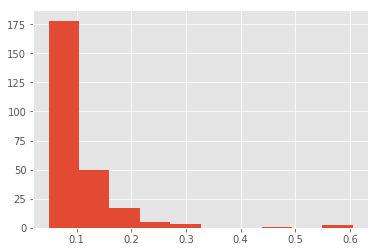

In [453]:
X.pay_price_per_hour[X.pay_price_per_hour>.05].apply(lambda x: np.log(x+1)).hist();


In [454]:
%%time
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
gp_size = 10
sreg = SymbolicTransformer(population_size=500,n_components=gp_size,
                           generations=50, stopping_criteria=0.01,
                           function_set=function_set,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.2, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1, n_jobs= 8,
                           parsimony_coefficient=0.01)
sreg.fit(X,y)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.52 0.15382249168286435        4 0.5808138205487405 0.5706366154366226     10.82m
Wall time: 21.1 s


test correlation between systhetic factor and dependend variable

In [455]:
gp_features =sreg.transform(X)
df_gp_features = pd.DataFrame(gp_features, columns =list(map(lambda x: 'gp_'+str(x),range(gp_size))))
X_gp=X.reset_index(drop=True).join(df_gp_features)

划分训练测试集

In [456]:
from sklearn.model_selection import train_test_split

def split_train_evaluate(df, train_ratio=0.8):
    """
        split dataset by register_date
    """
    max_days =  df.day_num.max()
    cutoff_daynum = int(train_ratio*max_days)
    df_train = df[df.day_num<cutoff_daynum]
    df_evaluate = df[df.day_num>=cutoff_daynum]
    return df_train, df_evaluate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

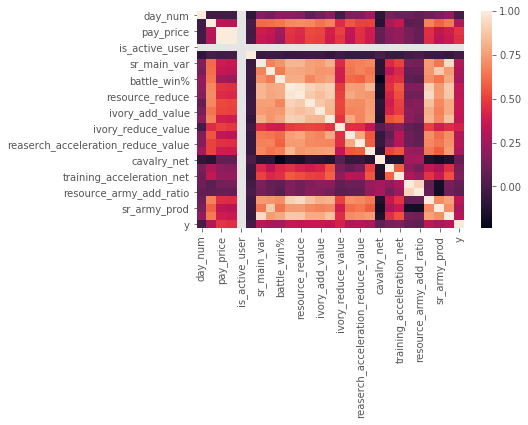

In [425]:
corr = X_test.assign(y=y_test).corr('spearman')
sns.heatmap(corr);

In [426]:
threshold = 0.85
correlated_pairs= {}
for col in corr:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(corr.index[abs(corr[col]) > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars
correlated_pairs


{'day_num': [],
 'avg_online_minutes': [],
 'pay_price': ['pay_price_per_hour'],
 'pay_price_per_hour': ['pay_price'],
 'is_active_user': [],
 'dayofweek': [],
 'sr_main_var': ['bd_sr_product'],
 'sr_level_var': ['sr_army_prod'],
 'battle_win%': [],
 'resource_add': ['resource_reduce',
  'stone_add_value',
  'ivory_add_value',
  'general_acceleration_add_value',
  'bd_resource_ratio',
  'bd_sr_product'],
 'resource_reduce': ['resource_add',
  'stone_add_value',
  'ivory_add_value',
  'general_acceleration_add_value',
  'bd_resource_ratio',
  'bd_sr_product'],
 'stone_add_value': ['resource_add',
  'resource_reduce',
  'ivory_add_value',
  'bd_resource_ratio'],
 'ivory_add_value': ['resource_add', 'resource_reduce', 'stone_add_value'],
 'general_acceleration_add_value': ['resource_add',
  'resource_reduce',
  'bd_sr_product'],
 'ivory_reduce_value': [],
 'general_acceleration_reduce_value': [],
 'reaserch_acceleration_reduce_value': [],
 'meat_net': [],
 'cavalry_net': [],
 'general_acc

使用Logistic Regression预测7日后是否付费

In [469]:
from os import cpu_count
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, Ridge
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2, f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import auc, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.pipeline import make_pipeline
import itertools as it

scaler_X = StandardScaler()
clf_models = []

c = LassoCV()

md_l2 = Ridge() #class_weight='balanced',

clf = RandomForestRegressor(verbose=True, n_jobs=cpu_count(), 
                             min_samples_leaf = 1,#class_weight='balanced',
                             n_estimators=100, max_depth =11)
pipeline_clf = make_pipeline(scaler_X,SelectFromModel(md_l1, threshold='median'), md_l2)
pipeline_clf.fit(X_train,y_train);

data = {'train':[X_train, y_train],'test':[X_test,y_test]}
y_stacked = {'train':{},'test':{}}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = pipeline_clf.predict(X_in)
    r2 = r2_score(y_predict, y_in)
    rmse = np.sqrt(mean_squared_error(y_predict, y_in))
    print("{0}: r2={1},rmse={2}".format(stage, r2, rmse))
    y_stacked[stage]['linear']=y_predict
clf_models.append(('linear',pipeline_clf ))

train: r2=-0.5524882538527673,rmse=210.04151306566047
test: r2=-1.070848927499811,rmse=208.21252421243776


fit with bayesian

In [471]:
%%time
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import BayesianRidge

pipeline_clf = make_pipeline(scaler_X,SelectFromModel(md_l1, threshold='median'), BayesianRidge())

pipeline_clf.fit(X_train, y_train)

data = {'train':[X_train, y_train],'test':[X_test,y_test]}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = pipeline_clf.predict(X_in)
    r2 = r2_score(y_predict, y_in)
    rmse = np.sqrt(mean_squared_error(y_predict, y_in))
    print("{0}: r2={1},rmse={2}".format(stage, r2, rmse))
    y_stacked[stage]['BayesianRidge']=y_predict
clf_models.append(('BayesianRidge',pipeline_clf ))

train: r2=-0.5529402599167359,rmse=210.04152127935416
test: r2=-1.0709044039584175,rmse=208.20399150563406
Wall time: 4.1 s


fit with AdaBoost

In [472]:
%%time
from sklearn.ensemble import AdaBoostRegressor

pipeline_clf = make_pipeline(AdaBoostRegressor(learning_rate=.3))

pipeline_clf.fit(X_train, y_train)

data = {'train':[X_train, y_train],'test':[X_test,y_test]}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = pipeline_clf.predict(X_in)
    r2 = r2_score(y_predict, y_in)
    rmse = np.sqrt(mean_squared_error(y_predict, y_in))
    print("{0}: r2={1},rmse={2}".format(stage, r2, rmse))
    y_stacked[stage]['BayesianRidge']=y_predict
clf_models.append(('BayesianRidge',pipeline_clf ))

train: r2=0.4088360337375372,rmse=233.35561609478077
test: r2=0.11943806701273985,rmse=258.8543651463588
Wall time: 31.6 s


predit with regression

In [508]:
def split_train_evaluate(df, train_ratio=0.8):
    """
        split dataset by register_date
    """
    max_days =  df.day_num.max()
    cutoff_daynum = int(train_ratio*max_days)
    train_index = df.day_num<cutoff_daynum
    evaluate_index = df.day_num>=cutoff_daynum
    return train_index, evaluate_index

train,test = split_train_evaluate(X,train_ratio=.7)
X_train, X_test= X[train],X[test]
y_train, y_test = y[train].prediction_future_pay_price,y[test].prediction_future_pay_price

In [509]:
%%time
import lightgbm as lgb 


train_data=lgb.Dataset(X_train,label=y_train)
param = {'num_leaves':150, 'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric':'rmse','max_depth':-1,'learning_rate':0.02,'max_bin':100, 'reg_lambda':0.03,'reg_alpha':0,
         'subsample' : 0.3,#'feature_fraction':0.6,
         'is_unbalance': 'false',  #because training data is unbalance (replaced with scale_pos_weight)
        }
# param['metric'] = ['l1']
num_round=300

lgbm=lgb.train(param,train_data,num_round)


Wall time: 5.28 s


In [510]:
from sklearn.metrics import r2_score, mean_squared_error
import math

data = {'train':[X_train, y_train],'test':[X_test,y_test]}
y_stacked = {'train':{},'test':{}}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = lgbm.predict(X_in)
    r2 = r2_score(y_predict, y_in)
    rmse = np.sqrt(mean_squared_error(y_predict, y_in))
    print("{0}: r2={1},rmse={2}".format(stage, r2, rmse))


train: r2=0.4327844464766001,rmse=137.74128709196702
test: r2=-0.5272751092898496,rmse=221.52443897771317


In [511]:
from sklearn.linear_model import BayesianRidge, Lasso, Ridge
pipeline_reg = make_pipeline(scaler_X,SelectFromModel(Lasso(), threshold='median'), Ridge())
pipeline_reg.fit(X_train,y_train)

data = {'train':[X_train, y_train],'test':[X_test,y_test]}

for stage in data.keys():
    X_in, y_in = data.get(stage)
    y_predict = pipeline_reg.predict(X_in)
    rmse = math.sqrt(mean_squared_error(y_predict, y_in))
    print("{0}: rmse={1}".format(stage, rmse))


train: rmse=209.98497288098307
test: rmse=210.70732771787908


In [490]:
X_test = df_test[NUMERICAL_COLUMNS]
y_predict_not_pay = pd.read_csv('notebook/y_predict_not_pay.csv')
submission = np.exp(lgbm.predict(X_test))-1
submission[y_predict_not_pay==True]=0

FileNotFoundError: File b'notebook/y_predict_not_pay.csv' does not exist

In [ ]:
plt.hist(submission)

In [ ]:
df_sub = pd.DataFrame({'user_id':df_test['user_id'].values,'prediction_pay_price':submission})
df_sub.to_csv('submission.csv', index=False)

![](https://upload-images.jianshu.io/upload_images/4563513-885b0f7338a4af99.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/396)